# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [1]:
%matplotlib inline
%load_ext Cython
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Reading Data

In [2]:
project_data = pd.read_csv('preprocessed_data.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 21)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'Unnamed: 0.1' 'id' 'teacher_id' 'teacher_prefix'
 'school_state' 'project_submitted_datetime' 'project_grade_category'
 'project_essay_1' 'project_essay_2' 'project_essay_3' 'project_essay_4'
 'project_resource_summary' 'teacher_number_of_previously_posted_projects'
 'project_is_approved' 'clean_categories' 'clean_subcategories'
 'preprocessed_titles' 'preprocessed_essays' 'price' 'quantity']


## 1.2 preprocessing of `project_subject_categories`

## 1.3 preprocessing of `project_subject_subcategories`

## 1.3 Text preprocessing

<h2><font color='red'> 1.4 Preprocessing of `project_title`</font></h2>

## 1.5 Preparing data for models

In [4]:
project_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'teacher_id', 'teacher_prefix',
       'school_state', 'project_submitted_datetime', 'project_grade_category',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'preprocessed_titles',
       'preprocessed_essays', 'price', 'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.5.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

### 1.5.2 Vectorizing Text data

#### 1.5.2.1 Bag of words

#### 1.5.2.2 TFIDF vectorizer

#### 1.5.2.3 Using Pretrained Models: Avg W2V

#### 1.5.2.3 Using Pretrained Models: TFIDF weighted W2V

### 1.5.3 Vectorizing Numerical features

### 1.5.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

__ Computing Sentiment Scores__

In [6]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

for_sentiment = 'a person is a person no matter how small dr seuss i teach the smallest students with the biggest enthusiasm \
for learning my students learn in many different ways using all of our senses and multiple intelligences i use a wide range\
of techniques to help all my students succeed students in my class come from a variety of different backgrounds which makes\
for wonderful sharing of experiences and cultures including native americans our school is a caring community of successful \
learners which can be seen through collaborative student project based learning in and out of the classroom kindergarteners \
in my class love to work with hands on materials and have many different opportunities to practice a skill before it is\
mastered having the social skills to work cooperatively with friends is a crucial aspect of the kindergarten curriculum\
montana is the perfect place to learn about agriculture and nutrition my students love to role play in our pretend kitchen\
in the early childhood classroom i have had several kids ask me can we try cooking with real food i will take their idea \
and create common core cooking lessons where we learn important math and writing concepts while cooking delicious healthy \
food for snack time my students will have a grounded appreciation for the work that went into making the food and knowledge \
of where the ingredients came from as well as how it is healthy for their bodies this project would expand our learning of \
nutrition and agricultural cooking recipes by having us peel our own apples to make homemade applesauce make our own bread \
and mix up healthy plants from our classroom garden in the spring we will also create our own cookbooks to be printed and \
shared with families students will gain math and literature skills as well as a life long enjoyment for healthy cooking \
nannan'
ss = sid.polarity_scores(for_sentiment)

for k in ss:
    print('{0}: {1}, '.format(k, ss[k]), end='')

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

C:\Users\Sai_Anirudh\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



neg: 0.01, neu: 0.745, pos: 0.245, compound: 0.9975, 

# Assignment 9: RF and GBDT

#### Response Coding: Example

<img src='response.JPG' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.5]

<ol>
    <li><strong>Apply both Random Forrest and GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V). Here for this set take <b>20K</b> datapoints only. </li>
            <li><font color='red'>Set 4</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V). Here for this set take <b>20K</b> datapoints only. </li>        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters preferably n_estimators, max_depth)</strong>
        <ul>
          <li> Consider the following range for hyperparameters <b>n_estimators</b> = [10, 50, 100, 150, 200, 300, 500, 1000], 
            <b>max_depth</b> = [2, 3, 4, 5, 6, 7, 8, 9, 10] </li>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using simple cross validation data</li>
    <li>You can write your own for loops to do this task</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You can choose either of the plotting techniques: 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
            </ul>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. Random Forest and GBDT </h1>

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

__We are using 50k data points for bow,tfidf and 20k datapoints for avgw2v and tfidfw2v as mentioned in the instructions__


In [7]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.model_selection import train_test_split
Y=project_data[['project_is_approved']]
X=project_data[['clean_categories','clean_subcategories','school_state','teacher_prefix','project_grade_category','price','teacher_number_of_previously_posted_projects','preprocessed_titles','preprocessed_essays']]


In [8]:
X1=X[0:50000]
Y1=Y[0:50000]

In [9]:
X2=X[0:20000]
Y2=Y[0:20000]

In [10]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.2) # this is random splitting
X_train1, X_cv1, y_train1, y_cv1 = train_test_split(X_train1, y_train1, test_size=0.2) # this is random splitting


print(X_train1.shape, y_train1.shape)
print(X_cv1.shape, y_cv1.shape)
print(X_test1.shape, y_test1.shape)
print("="*100)

(32000, 9) (32000, 1)
(8000, 9) (8000, 1)
(10000, 9) (10000, 1)


In [11]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.2) # this is random splitting
X_train2, X_cv2, y_train2, y_cv2 = train_test_split(X_train2, y_train2, test_size=0.2) # this is random splitting


print(X_train2.shape, y_train2.shape)
print(X_cv2.shape, y_cv2.shape)
print(X_test2.shape, y_test2.shape)
print("="*100)

(12800, 9) (12800, 1)
(3200, 9) (3200, 1)
(4000, 9) (4000, 1)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

## Encoding Categorical Features

## Custom Response Coding Function Definition

In [620]:
def response_coding(categorical_var,categorical_training_var,training_output):    
    xtvc0=((categorical_training_var.loc[(training_output==0)].value_counts())/(categorical_training_var.value_counts())).fillna(0)
    xtvc1=((categorical_training_var.loc[(training_output==1)].value_counts())/(categorical_training_var.value_counts())).fillna(0)
    cc=categorical_var.values
    m=categorical_var.shape[0]
    n=2
    rccv=[[0 for i in range(n)] for j in range(m)]
    xtvci=categorical_training_var.value_counts().index.tolist()
    xtvc=categorical_training_var.value_counts()
    for i in range(0,categorical_var.shape[0],1):
        for j in range(0,xtvc.shape[0],1):
            if(cc[i]==xtvci[j]):
                rccv[i][0]=xtvc0[j]
                rccv[i][1]=xtvc1[j]
            if(cc[i] not in xtvci):
                rccv[i][0]=0.5
                rccv[i][1]=0.5
    rccv=np.array(rccv)
    return rccv

In [621]:
categories_rc_train1=response_coding(X_train1['clean_categories'],X_train1['clean_categories'],y_train1['project_is_approved'])
categories_rc_cv1=response_coding(X_cv1['clean_categories'],X_train1['clean_categories'],y_train1['project_is_approved'])
categories_rc_test1=response_coding(X_test1['clean_categories'],X_train1['clean_categories'],y_train1['project_is_approved'])

In [622]:
categories_rc_train2=response_coding(X_train2['clean_categories'],X_train2['clean_categories'],y_train2['project_is_approved'])
categories_rc_cv2=response_coding(X_cv2['clean_categories'],X_train2['clean_categories'],y_train2['project_is_approved'])
categories_rc_test2=response_coding(X_test2['clean_categories'],X_train2['clean_categories'],y_train2['project_is_approved'])

In [623]:
sub_categories_rc_train1=response_coding(X_train1['clean_subcategories'],X_train1['clean_subcategories'],y_train1['project_is_approved'])
sub_categories_rc_cv1=response_coding(X_cv1['clean_subcategories'],X_train1['clean_subcategories'],y_train1['project_is_approved'])
sub_categories_rc_test1=response_coding(X_test1['clean_subcategories'],X_train1['clean_subcategories'],y_train1['project_is_approved'])

In [624]:
sub_categories_rc_train2=response_coding(X_train2['clean_subcategories'],X_train2['clean_subcategories'],y_train2['project_is_approved'])
sub_categories_rc_cv2=response_coding(X_cv2['clean_subcategories'],X_train2['clean_subcategories'],y_train2['project_is_approved'])
sub_categories_rc_test2=response_coding(X_test2['clean_subcategories'],X_train2['clean_subcategories'],y_train2['project_is_approved'])

In [625]:
school_state_rc_train1=response_coding(X_train1['school_state'],X_train1['school_state'],y_train1['project_is_approved'])
school_state_rc_cv1=response_coding(X_cv1['school_state'],X_train1['school_state'],y_train1['project_is_approved'])
school_state_rc_test1=response_coding(X_test1['school_state'],X_train1['school_state'],y_train1['project_is_approved'])

In [626]:
school_state_rc_train2=response_coding(X_train2['school_state'],X_train2['school_state'],y_train2['project_is_approved'])
school_state_rc_cv2=response_coding(X_cv2['school_state'],X_train2['school_state'],y_train2['project_is_approved'])
school_state_rc_test2=response_coding(X_test2['school_state'],X_train2['school_state'],y_train2['project_is_approved'])

In [627]:
teacher_prefix_rc_train1=response_coding(X_train1['teacher_prefix'],X_train1['teacher_prefix'],y_train1['project_is_approved'])
teacher_prefix_rc_cv1=response_coding(X_cv1['teacher_prefix'],X_train1['teacher_prefix'],y_train1['project_is_approved'])
teacher_prefix_rc_test1=response_coding(X_test1['teacher_prefix'],X_train1['teacher_prefix'],y_train1['project_is_approved'])

In [628]:
teacher_prefix_rc_train2=response_coding(X_train2['teacher_prefix'],X_train2['teacher_prefix'],y_train2['project_is_approved'])
teacher_prefix_rc_cv2=response_coding(X_cv2['teacher_prefix'],X_train2['teacher_prefix'],y_train2['project_is_approved'])
teacher_prefix_rc_test2=response_coding(X_test2['teacher_prefix'],X_train2['teacher_prefix'],y_train2['project_is_approved'])

In [629]:
project_grade_category_rc_train1=response_coding(X_train1['project_grade_category'],X_train1['project_grade_category'],y_train1['project_is_approved'])
project_grade_category_rc_cv1=response_coding(X_cv1['project_grade_category'],X_train1['project_grade_category'],y_train1['project_is_approved'])
project_grade_category_rc_test1=response_coding(X_test1['project_grade_category'],X_train1['project_grade_category'],y_train1['project_is_approved'])

In [630]:
project_grade_category_rc_train2=response_coding(X_train2['project_grade_category'],X_train2['project_grade_category'],y_train2['project_is_approved'])
project_grade_category_rc_cv2=response_coding(X_cv2['project_grade_category'],X_train2['project_grade_category'],y_train2['project_is_approved'])
project_grade_category_rc_test2=response_coding(X_test2['project_grade_category'],X_train2['project_grade_category'],y_train2['project_is_approved'])

## Encoding Numerical Features

In [632]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(X_train1['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized_train1 = price_scalar.transform(X_train1['price'].values.reshape(-1, 1))
price_standardized_cv1 = price_scalar.transform(X_cv1['price'].values.reshape(-1, 1))
price_standardized_test1 = price_scalar.transform(X_test1['price'].values.reshape(-1, 1))

Mean : 300.1559909375, Standard deviation : 389.30925279883445


In [633]:
price_scalar = StandardScaler()
price_scalar.fit(X_train2['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized_train2 = price_scalar.transform(X_train2['price'].values.reshape(-1, 1))
price_standardized_cv2 = price_scalar.transform(X_cv2['price'].values.reshape(-1, 1))
price_standardized_test2 = price_scalar.transform(X_test2['price'].values.reshape(-1, 1))

Mean : 299.8056289062499, Standard deviation : 385.03248795730065


In [634]:
import warnings
warnings.filterwarnings("ignore")

ppp_scalar = StandardScaler()
ppp_scalar.fit(X_train1['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {ppp_scalar.mean_[0]}, Standard deviation : {np.sqrt(ppp_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
ppp_standardized_train1 = ppp_scalar.transform(X_train1['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
ppp_standardized_cv1 = ppp_scalar.transform(X_cv1['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
ppp_standardized_test1 = ppp_scalar.transform(X_test1['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.2125625, Standard deviation : 28.13373539335994


In [635]:
ppp_scalar = StandardScaler()
ppp_scalar.fit(X_train2['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {ppp_scalar.mean_[0]}, Standard deviation : {np.sqrt(ppp_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
ppp_standardized_train2 = ppp_scalar.transform(X_train2['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
ppp_standardized_cv2 = ppp_scalar.transform(X_cv2['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
ppp_standardized_test2 = ppp_scalar.transform(X_test2['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.259296875, Standard deviation : 27.665310512546487


<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [12]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X_train1['preprocessed_essays'].astype('U'))
tvectorizer = CountVectorizer(min_df=10)
tvectorizer.fit(X_train1['preprocessed_titles'].astype('U'))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [13]:
text_bow_train = vectorizer.transform(X_train1['preprocessed_essays'])
print("Shape of matrix after one hot encodig ",text_bow_train.shape)

Shape of matrix after one hot encodig  (32000, 10187)


In [14]:
text_bow_cv = vectorizer.transform(X_cv1['preprocessed_essays'])
print("Shape of matrix after one hot encodig ",text_bow_cv.shape)

Shape of matrix after one hot encodig  (8000, 10187)


In [15]:
text_bow_test = vectorizer.transform(X_test1['preprocessed_essays'])
print("Shape of matrix after one hot encodig ",text_bow_test.shape)

Shape of matrix after one hot encodig  (10000, 10187)


In [16]:
title_text_bow_train = tvectorizer.transform(X_train1['preprocessed_titles'].astype('U'))
print("Shape of matrix after one hot encodig ",title_text_bow_train.shape)

Shape of matrix after one hot encodig  (32000, 1511)


In [17]:
title_text_bow_cv = tvectorizer.transform(X_cv1['preprocessed_titles'].astype('U'))
print("Shape of matrix after one hot encodig ",title_text_bow_cv.shape)

Shape of matrix after one hot encodig  (8000, 1511)


In [18]:
title_text_bow_test = tvectorizer.transform(X_test1['preprocessed_titles'].astype('U'))
print("Shape of matrix after one hot encodig ",title_text_bow_test.shape)

Shape of matrix after one hot encodig  (10000, 1511)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfevectorizer = TfidfVectorizer(min_df=10)
tfevectorizer.fit(X_train1['preprocessed_essays'].astype('U'))
tftvectorizer = TfidfVectorizer(min_df=10)
tftvectorizer.fit(X_train1['preprocessed_titles'].astype('U'))


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [20]:
text_tfidf_train = tfevectorizer.transform(X_train1['preprocessed_essays'])
print("Shape of matrix after one hot encodig ",text_tfidf_train.shape)

Shape of matrix after one hot encodig  (32000, 10187)


In [21]:
text_tfidf_cv = tfevectorizer.transform(X_cv1['preprocessed_essays'])
print("Shape of matrix after one hot encodig ",text_tfidf_cv.shape)

Shape of matrix after one hot encodig  (8000, 10187)


In [22]:
text_tfidf_test = tfevectorizer.transform(X_test1['preprocessed_essays'])
print("Shape of matrix after one hot encodig ",text_tfidf_test.shape)

Shape of matrix after one hot encodig  (10000, 10187)


In [23]:
title_text_tfidf_train = tftvectorizer.transform(X_train1['preprocessed_titles'].astype('U'))
print("Shape of matrix after one hot encodig ",title_text_tfidf_train.shape)

Shape of matrix after one hot encodig  (32000, 1511)


In [24]:
title_text_tfidf_cv = tftvectorizer.transform(X_cv1['preprocessed_titles'].astype('U'))
print("Shape of matrix after one hot encodig ",title_text_tfidf_cv.shape)

Shape of matrix after one hot encodig  (8000, 1511)


In [25]:
title_text_tfidf_test = tftvectorizer.transform(X_test1['preprocessed_titles'].astype('U'))
print("Shape of matrix after one hot encodig ",title_text_tfidf_test.shape)

Shape of matrix after one hot encodig  (10000, 1511)


In [29]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')
'''
# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================
'''
words = []
for i in X_train2['preprocessed_essays'].astype('U'):
    words.extend(i.split(' '))

for i in X_train2['preprocessed_titles'].astype('U'):
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


Loading Glove Model


1917495it [21:49, 1464.08it/s]


Done. 1917495  words loaded!
all the words in the coupus 1814414
the unique words in the coupus 25377
The number of words that are present in both glove vectors and our coupus 24254 ( 95.575 %)
word 2 vec length 24254


In [32]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [33]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train2['preprocessed_essays'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_train.append(vector)

print(len(avg_w2v_vectors_train))
print(len(avg_w2v_vectors_train[0]))

100%|███████████████████████████████████| 12800/12800 [00:15<00:00, 825.00it/s]


12800
300


In [34]:
avg_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv2['preprocessed_essays'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_cv.append(vector)

print(len(avg_w2v_vectors_cv))
print(len(avg_w2v_vectors_cv[0]))

100%|█████████████████████████████████████| 3200/3200 [00:04<00:00, 700.68it/s]


3200
300


In [35]:
avg_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test2['preprocessed_essays'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_test.append(vector)

print(len(avg_w2v_vectors_test))
print(len(avg_w2v_vectors_test[0]))

100%|█████████████████████████████████████| 4000/4000 [00:04<00:00, 859.63it/s]


4000
300


In [36]:
title_avg_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train2['preprocessed_titles'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_avg_w2v_vectors_train.append(vector)

print(len(title_avg_w2v_vectors_train))
print(len(title_avg_w2v_vectors_train[0]))

100%|█████████████████████████████████| 12800/12800 [00:01<00:00, 12407.08it/s]


12800
300


In [37]:
title_avg_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv2['preprocessed_titles'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_avg_w2v_vectors_cv.append(vector)

print(len(title_avg_w2v_vectors_cv))
print(len(title_avg_w2v_vectors_cv[0]))

100%|████████████████████████████████████| 3200/3200 [00:00<00:00, 8861.31it/s]


3200
300


In [663]:
title_avg_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test2['preprocessed_titles'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    title_avg_w2v_vectors_test.append(vector)

print(len(title_avg_w2v_vectors_test))
print(len(title_avg_w2v_vectors_test[0]))

100%|████████████████████████████████████| 4000/4000 [00:00<00:00, 9992.80it/s]


4000
300


In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train2['preprocessed_essays'].astype('U'))
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [40]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train2['preprocessed_essays'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|███████████████████████████████████| 12800/12800 [01:54<00:00, 111.80it/s]


12800
300


In [41]:
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv2['preprocessed_essays'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|█████████████████████████████████████| 3200/3200 [00:28<00:00, 111.51it/s]


3200
300


In [42]:
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test2['preprocessed_essays'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|█████████████████████████████████████| 4000/4000 [00:38<00:00, 103.81it/s]


4000
300


In [43]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model2 = TfidfVectorizer()
tfidf_model2.fit(X_train2['preprocessed_titles'].astype('U'))
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model2.get_feature_names(), list(tfidf_model2.idf_)))
tfidf_words = set(tfidf_model2.get_feature_names())

In [44]:
# Similarly you can vectorize for title also
title_tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train2['preprocessed_titles'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_tfidf_w2v_vectors_train.append(vector)

print(len(title_tfidf_w2v_vectors_train))
print(len(title_tfidf_w2v_vectors_train[0]))

100%|██████████████████████████████████| 12800/12800 [00:02<00:00, 6059.37it/s]


12800
300


In [45]:
title_tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv2['preprocessed_titles'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_tfidf_w2v_vectors_cv.append(vector)

print(len(title_tfidf_w2v_vectors_cv))
print(len(title_tfidf_w2v_vectors_cv[0]))

100%|████████████████████████████████████| 3200/3200 [00:00<00:00, 6483.58it/s]


3200
300


In [46]:
title_tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test2['preprocessed_titles'].astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    title_tfidf_w2v_vectors_test.append(vector)

print(len(title_tfidf_w2v_vectors_test))
print(len(title_tfidf_w2v_vectors_test[0]))

100%|████████████████████████████████████| 4000/4000 [00:00<00:00, 6200.70it/s]


4000
300


In [670]:
with open('donorschoosetextnumcatencoded2.pickle', 'wb') as f:
    pickle.dump([X_train1,X_cv1,X_test1,X_train2,X_cv2,X_test2,y_train1,y_cv1,y_test1,y_train2,y_cv2,y_test2,categories_rc_train1,categories_rc_train2,categories_rc_cv1,categories_rc_cv2,categories_rc_test1,categories_rc_test2,sub_categories_rc_train1,sub_categories_rc_train2,sub_categories_rc_cv1,sub_categories_rc_cv2,sub_categories_rc_test1,sub_categories_rc_test2,school_state_rc_train1,school_state_rc_train2,school_state_rc_cv1,school_state_rc_cv2,school_state_rc_test1,school_state_rc_test2,teacher_prefix_rc_train1,teacher_prefix_rc_train2,teacher_prefix_rc_cv1,teacher_prefix_rc_cv2,teacher_prefix_rc_test1,teacher_prefix_rc_test2,project_grade_category_rc_train1,project_grade_category_rc_train2,project_grade_category_rc_cv1,project_grade_category_rc_cv2,project_grade_category_rc_test1,project_grade_category_rc_test2,price_standardized_train1,price_standardized_train2,price_standardized_cv1,price_standardized_cv2,price_standardized_test1,price_standardized_test2,ppp_standardized_train1,ppp_standardized_train2,ppp_standardized_cv1,ppp_standardized_cv2,ppp_standardized_test1,ppp_standardized_test2],f)

In [671]:
with open('donorschoosetextnumcatencoded3.pickle', 'wb') as f:
    pickle.dump([text_bow_train,text_bow_cv,text_bow_test,title_text_bow_train,title_text_bow_cv,title_text_bow_test,text_tfidf_train,text_tfidf_cv,text_tfidf_test,title_text_tfidf_train,title_text_tfidf_cv,title_text_tfidf_test,avg_w2v_vectors_train,avg_w2v_vectors_cv,avg_w2v_vectors_test,title_avg_w2v_vectors_train,title_avg_w2v_vectors_cv,title_avg_w2v_vectors_test,tfidf_w2v_vectors_train,tfidf_w2v_vectors_cv,tfidf_w2v_vectors_test,title_tfidf_w2v_vectors_train,title_tfidf_w2v_vectors_cv,title_tfidf_w2v_vectors_test],f)

In [661]:
with open('donorschoosetextnumcatencoded2.pickle', 'rb') as f:
    X_train1,X_cv1,X_test1,X_train2,X_cv2,X_test2,y_train1,y_cv1,y_test1,y_train2,y_cv2,y_test2,categories_rc_train1,categories_rc_train2,categories_rc_cv1,categories_rc_cv2,categories_rc_test1,categories_rc_test2,sub_categories_rc_train1,sub_categories_rc_train2,sub_categories_rc_cv1,sub_categories_rc_cv2,sub_categories_rc_test1,sub_categories_rc_test2,school_state_rc_train1,school_state_rc_train2,school_state_rc_cv1,school_state_rc_cv2,school_state_rc_test1,school_state_rc_test2,teacher_prefix_rc_train1,teacher_prefix_rc_train2,teacher_prefix_rc_cv1,teacher_prefix_rc_cv2,teacher_prefix_rc_test1,teacher_prefix_rc_test2,project_grade_category_rc_train1,project_grade_category_rc_train2,project_grade_category_rc_cv1,project_grade_category_rc_cv2,project_grade_category_rc_test1,project_grade_category_rc_test2,price_standardized_train1,price_standardized_train2,price_standardized_cv1,price_standardized_cv2,price_standardized_test1,price_standardized_test2,ppp_standardized_train1,ppp_standardized_train2,ppp_standardized_cv1,ppp_standardized_cv2,ppp_standardized_test1,ppp_standardized_test2=pickle.load(f)

In [662]:
with open('donorschoosetextnumcatencoded3.pickle', 'rb') as f:
    text_bow_train,text_bow_cv,text_bow_test,title_text_bow_train,title_text_bow_cv,title_text_bow_test,text_tfidf_train,text_tfidf_cv,text_tfidf_test,title_text_tfidf_train,title_text_tfidf_cv,title_text_tfidf_test,avg_w2v_vectors_train,avg_w2v_vectors_cv,avg_w2v_vectors_test,title_avg_w2v_vectors_train,title_avg_w2v_vectors_cv,title_avg_w2v_vectors_test,tfidf_w2v_vectors_train,tfidf_w2v_vectors_cv,tfidf_w2v_vectors_test,title_tfidf_w2v_vectors_train,title_tfidf_w2v_vectors_cv,title_tfidf_w2v_vectors_test=pickle.load(f)

In [663]:
from scipy.sparse import hstack
X_train_bow = hstack((categories_rc_train1,sub_categories_rc_train1,school_state_rc_train1,teacher_prefix_rc_train1, project_grade_category_rc_train1, price_standardized_train1, ppp_standardized_train1, title_text_bow_train, text_bow_train))
X_train_bow.shape

(32000, 11710)

In [664]:
X_cv_bow = hstack((categories_rc_cv1,sub_categories_rc_cv1,school_state_rc_cv1,teacher_prefix_rc_cv1, project_grade_category_rc_cv1, price_standardized_cv1, ppp_standardized_cv1, title_text_bow_cv, text_bow_cv))
X_cv_bow.shape

(8000, 11710)

In [665]:
X_test_bow = hstack((categories_rc_test1,sub_categories_rc_test1,school_state_rc_test1,teacher_prefix_rc_test1, project_grade_category_rc_test1, price_standardized_test1, ppp_standardized_test1, title_text_bow_test, text_bow_test))
X_test_bow.shape

(10000, 11710)

In [666]:
X_train_tfidf = hstack((categories_rc_train1,sub_categories_rc_train1,school_state_rc_train1,teacher_prefix_rc_train1, project_grade_category_rc_train1, price_standardized_train1, ppp_standardized_train1, title_text_tfidf_train, text_tfidf_train))
X_train_tfidf.shape

(32000, 11710)

In [667]:
X_cv_tfidf = hstack((categories_rc_cv1,sub_categories_rc_cv1,school_state_rc_cv1,teacher_prefix_rc_cv1, project_grade_category_rc_cv1, price_standardized_cv1, ppp_standardized_cv1, title_text_tfidf_cv, text_tfidf_cv))
X_cv_tfidf.shape

(8000, 11710)

In [668]:
X_test_tfidf = hstack((categories_rc_test1,sub_categories_rc_test1,school_state_rc_test1,teacher_prefix_rc_test1, project_grade_category_rc_test1, price_standardized_test1, ppp_standardized_test1, title_text_tfidf_test, text_tfidf_test))
X_test_tfidf.shape

(10000, 11710)

In [669]:
X_train_avgw2v = np.hstack((categories_rc_train2,sub_categories_rc_train2,school_state_rc_train2,teacher_prefix_rc_train2, project_grade_category_rc_train2, price_standardized_train2, ppp_standardized_train2, title_avg_w2v_vectors_train, avg_w2v_vectors_train))
X_train_avgw2v.shape

(12800, 612)

In [670]:
X_cv_avgw2v = np.hstack((categories_rc_cv2,sub_categories_rc_cv2,school_state_rc_cv2,teacher_prefix_rc_cv2, project_grade_category_rc_cv2, price_standardized_cv2, ppp_standardized_cv2, title_avg_w2v_vectors_cv, avg_w2v_vectors_cv))
X_cv_avgw2v.shape

(3200, 612)

In [671]:
X_test_avgw2v = np.hstack((categories_rc_test2,sub_categories_rc_test2,school_state_rc_test2,teacher_prefix_rc_test2, project_grade_category_rc_test2, price_standardized_test2, ppp_standardized_test2, title_avg_w2v_vectors_test, avg_w2v_vectors_test))
X_test_avgw2v.shape

(4000, 612)

In [672]:
X_train_tfidfw2v = np.hstack((categories_rc_train2,sub_categories_rc_train2,school_state_rc_train2,teacher_prefix_rc_train2, project_grade_category_rc_train2, price_standardized_train2, ppp_standardized_train2, title_tfidf_w2v_vectors_train, tfidf_w2v_vectors_train))
X_train_tfidfw2v.shape

(12800, 612)

In [673]:
X_cv_tfidfw2v = np.hstack((categories_rc_cv2,sub_categories_rc_cv2,school_state_rc_cv2,teacher_prefix_rc_cv2, project_grade_category_rc_cv2, price_standardized_cv2, ppp_standardized_cv2, title_tfidf_w2v_vectors_cv, tfidf_w2v_vectors_cv))
X_cv_tfidfw2v.shape

(3200, 612)

In [674]:
X_test_tfidfw2v = np.hstack((categories_rc_test2,sub_categories_rc_test2,school_state_rc_test2,teacher_prefix_rc_test2, project_grade_category_rc_test2, price_standardized_test2, ppp_standardized_test2, title_tfidf_w2v_vectors_test, tfidf_w2v_vectors_test))
X_test_tfidfw2v.shape

(4000, 612)

<h2>2.4 Applying Random Forest</h2>

<br>Apply Random Forest on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [675]:
y_train1['project_is_approved'].value_counts()

1    27026
0     4974
Name: project_is_approved, dtype: int64

### 2.4.1 Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [676]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [686]:
%%time
m=len(ne)
n=len(md)
trauc=[[0 for a in range(n)] for b in range(m)]
cvauc=[[0 for a in range(n)] for b in range(m)]
for i in range(0,len(md),1):
    for j in range(0,len(ne),1):
        clf1=RandomForestClassifier(n_estimators=ne[j],max_depth=md[i],n_jobs=-1,class_weight='balanced')
        clf1.fit(X_train_bow,y_train1.values.ravel())
        train_fpr1, train_tpr1, thresholds = roc_curve(y_train1,clf1.predict_proba(X_train_bow)[:,1])
        trauc[j][i]=auc(train_fpr1, train_tpr1)
        cv_fpr1, cv_tpr1, thresholds = roc_curve(y_cv1,clf1.predict_proba(X_cv_bow)[:,1])
        cvauc[j][i]=auc(cv_fpr1, cv_tpr1)

Wall time: 10min 5s


In [688]:
trauc=np.array(trauc)
cvauc=np.array(cvauc)

In [691]:
trauc.shape

(8, 9)

In [692]:
cvauc.shape

(8, 9)

In [694]:
df_trainauc=pd.DataFrame(trauc)

In [695]:
df_trainauc

0         1         2         3         4         5         6  \
0  0.599886  0.609263  0.632632  0.670045  0.676289  0.694790  0.711399   
1  0.685391  0.694230  0.707211  0.739468  0.762648  0.771594  0.798449   
2  0.705987  0.722799  0.740403  0.757168  0.773322  0.783099  0.814398   
3  0.710156  0.720601  0.742166  0.759471  0.776676  0.796525  0.817833   
4  0.722722  0.723972  0.749294  0.771102  0.776816  0.802428  0.823380   
5  0.722623  0.726160  0.755187  0.769414  0.784935  0.803281  0.822133   
6  0.725196  0.738369  0.748059  0.770637  0.784088  0.799459  0.823706   
7  0.729292  0.737138  0.755278  0.770971  0.789221  0.809790  0.824915   

          7         8  
0  0.728595  0.752837  
1  0.806321  0.824726  
2  0.829852  0.845947  
3  0.829880  0.857265  
4  0.833402  0.855228  
5  0.841870  0.855314  
6  0.840695  0.858543  
7  0.842481  0.863328

In [696]:
df_cvauc=pd.DataFrame(cvauc)

In [697]:
df_cvauc

0         1         2         3         4         5         6  \
0  0.567335  0.606026  0.598014  0.627356  0.634106  0.648363  0.628947   
1  0.668345  0.657376  0.666540  0.680717  0.691178  0.689818  0.690598   
2  0.690060  0.682706  0.694533  0.697670  0.695144  0.698532  0.701332   
3  0.690382  0.691960  0.700124  0.696577  0.700238  0.695598  0.711305   
4  0.702934  0.689999  0.699811  0.710448  0.705171  0.703577  0.712147   
5  0.694042  0.693542  0.698511  0.707386  0.705474  0.706393  0.708900   
6  0.705487  0.704934  0.699986  0.709526  0.704685  0.707532  0.713069   
7  0.707241  0.702084  0.705061  0.704566  0.709831  0.712786  0.712384   

          7         8  
0  0.641907  0.656508  
1  0.680829  0.697870  
2  0.705652  0.703379  
3  0.702720  0.712024  
4  0.704425  0.709258  
5  0.714485  0.706313  
6  0.710470  0.712783  
7  0.711133  0.715756

In [698]:
df_trainauc.index=ne

In [699]:
df_trainauc.columns=md

In [700]:
df_trainauc

2         3         4         5         6         7         8   \
10    0.599886  0.609263  0.632632  0.670045  0.676289  0.694790  0.711399   
50    0.685391  0.694230  0.707211  0.739468  0.762648  0.771594  0.798449   
100   0.705987  0.722799  0.740403  0.757168  0.773322  0.783099  0.814398   
150   0.710156  0.720601  0.742166  0.759471  0.776676  0.796525  0.817833   
200   0.722722  0.723972  0.749294  0.771102  0.776816  0.802428  0.823380   
300   0.722623  0.726160  0.755187  0.769414  0.784935  0.803281  0.822133   
500   0.725196  0.738369  0.748059  0.770637  0.784088  0.799459  0.823706   
1000  0.729292  0.737138  0.755278  0.770971  0.789221  0.809790  0.824915   

            9         10  
10    0.728595  0.752837  
50    0.806321  0.824726  
100   0.829852  0.845947  
150   0.829880  0.857265  
200   0.833402  0.855228  
300   0.841870  0.855314  
500   0.840695  0.858543  
1000  0.842481  0.863328

In [701]:
df_cvauc.index=ne

In [702]:
df_cvauc.columns=md

In [703]:
df_cvauc

2         3         4         5         6         7         8   \
10    0.567335  0.606026  0.598014  0.627356  0.634106  0.648363  0.628947   
50    0.668345  0.657376  0.666540  0.680717  0.691178  0.689818  0.690598   
100   0.690060  0.682706  0.694533  0.697670  0.695144  0.698532  0.701332   
150   0.690382  0.691960  0.700124  0.696577  0.700238  0.695598  0.711305   
200   0.702934  0.689999  0.699811  0.710448  0.705171  0.703577  0.712147   
300   0.694042  0.693542  0.698511  0.707386  0.705474  0.706393  0.708900   
500   0.705487  0.704934  0.699986  0.709526  0.704685  0.707532  0.713069   
1000  0.707241  0.702084  0.705061  0.704566  0.709831  0.712786  0.712384   

            9         10  
10    0.641907  0.656508  
50    0.680829  0.697870  
100   0.705652  0.703379  
150   0.702720  0.712024  
200   0.704425  0.709258  
300   0.714485  0.706313  
500   0.710470  0.712783  
1000  0.711133  0.715756

In [704]:
df_joined=df_trainauc.join(df_cvauc,lsuffix='_train',rsuffix='_cv')

In [705]:
df_joined

2_train   3_train   4_train   5_train   6_train   7_train   8_train  \
10    0.599886  0.609263  0.632632  0.670045  0.676289  0.694790  0.711399   
50    0.685391  0.694230  0.707211  0.739468  0.762648  0.771594  0.798449   
100   0.705987  0.722799  0.740403  0.757168  0.773322  0.783099  0.814398   
150   0.710156  0.720601  0.742166  0.759471  0.776676  0.796525  0.817833   
200   0.722722  0.723972  0.749294  0.771102  0.776816  0.802428  0.823380   
300   0.722623  0.726160  0.755187  0.769414  0.784935  0.803281  0.822133   
500   0.725196  0.738369  0.748059  0.770637  0.784088  0.799459  0.823706   
1000  0.729292  0.737138  0.755278  0.770971  0.789221  0.809790  0.824915   

       9_train  10_train      2_cv      3_cv      4_cv      5_cv      6_cv  \
10    0.728595  0.752837  0.567335  0.606026  0.598014  0.627356  0.634106   
50    0.806321  0.824726  0.668345  0.657376  0.666540  0.680717  0.691178   
100   0.829852  0.845947  0.690060  0.682706  0.694533  0.697670  0.695144   
150   0.829880  0.857265  0.690382  0.691960  0.700124  0.696577  0.700238   
200   0.833402  0.855228  0.702934  0.689999  0.699811  0.710448  0.705171   
300   0.841870  0.855314  0.694042  0.693542  0.698511  0.707386  0.705474   
500   0.840695  0.858543  0.705487  0.704934  0.699986  0.709526  0.704685   
1000  0.842481  0.863328  0.707241  0.702084  0.705061  0.704566  0.709831   

          7_cv      8_cv      9_cv     10_cv  
10    0.648363  0.628947  0.641907  0.656508  
50    0.689818  0.690598  0.680829  0.697870  
100   0.698532  0.701332  0.705652  0.703379  
150   0.695598  0.711305  0.702720  0.712024  
200   0.703577  0.712147  0.704425  0.709258  
300   0.706393  0.708900  0.714485  0.706313  
500   0.707532  0.713069  0.710470  0.712783  
1000  0.712786  0.712384  0.711133  0.715756

In [706]:
(df_trainauc-df_cvauc)

2         3         4         5         6         7         8   \
10    0.032551  0.003237  0.034618  0.042689  0.042184  0.046427  0.082453   
50    0.017046  0.036854  0.040671  0.058750  0.071470  0.081776  0.107851   
100   0.015927  0.040092  0.045870  0.059498  0.078178  0.084567  0.113066   
150   0.019774  0.028641  0.042042  0.062894  0.076437  0.100927  0.106528   
200   0.019788  0.033973  0.049483  0.060654  0.071645  0.098850  0.111232   
300   0.028581  0.032618  0.056676  0.062028  0.079461  0.096887  0.113233   
500   0.019709  0.033435  0.048073  0.061111  0.079404  0.091927  0.110637   
1000  0.022051  0.035054  0.050217  0.066405  0.079390  0.097004  0.112531   

            9         10  
10    0.086688  0.096329  
50    0.125491  0.126856  
100   0.124200  0.142568  
150   0.127159  0.145241  
200   0.128977  0.145971  
300   0.127385  0.149000  
500   0.130225  0.145760  
1000  0.131348  0.147572

Training data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

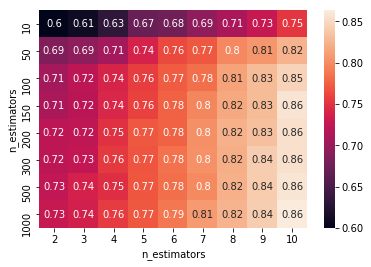

In [707]:
print("Training data AUC heatmap")
print(sns.heatmap(df_trainauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

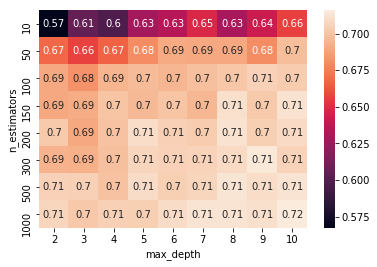

In [708]:
print("Cross validation data AUC heatmap")
print(sns.heatmap(df_cvauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Difference between training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

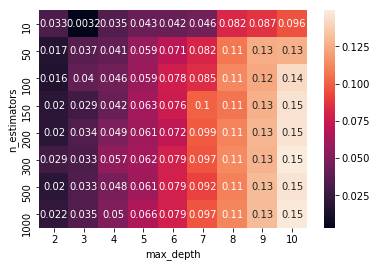

In [709]:
print("Difference between training and cross validation data AUC heatmap")
print(sns.heatmap((df_trainauc-df_cvauc),annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

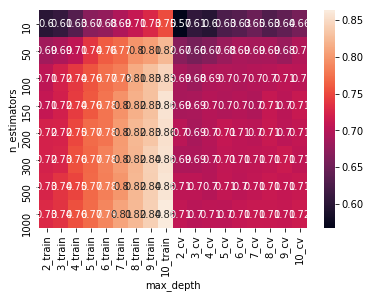

In [710]:
print("Training and cross validation data AUC heatmap")
print(sns.heatmap(df_joined,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

In [711]:
bestne=500
bestmd=2

In [712]:
%%time
clf1=RandomForestClassifier(n_estimators=bestne,max_depth=bestmd,n_jobs=-1,class_weight='balanced')
clf1.fit(X_train_bow,y_train1.values.ravel())

Wall time: 6.3 s


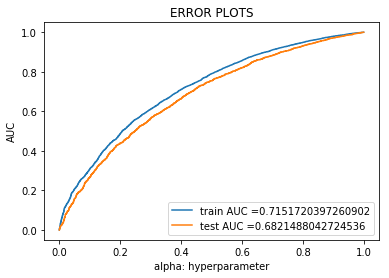

In [713]:
train_fpr1, train_tpr1, thresholds = roc_curve(y_train1,clf1.predict_proba(X_train_bow)[:,1])

test_fpr1, test_tpr1, thresholds = roc_curve(y_test1,clf1.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


Train confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

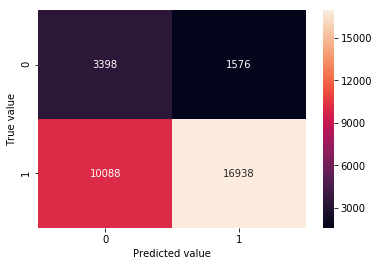

In [714]:
print("Train confusion matrix")
trcm=confusion_matrix(y_train1, clf1.predict(X_train_bow))
print(sns.heatmap(trcm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

Test confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

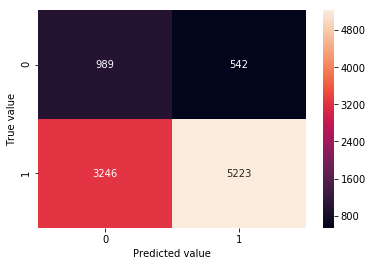

In [715]:
print("Test confusion matrix")
tecm=confusion_matrix(y_test1, clf1.predict(X_test_bow))
print(sns.heatmap(tecm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

### 2.4.2 Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [718]:
md=[2,3,4,5,6,7,8,9,10]
ne=[10,50,100,150,200,300,500,1000]
m=len(ne)
n=len(md)
trauc=[[0 for a in range(n)] for b in range(m)]
cvauc=[[0 for a in range(n)] for b in range(m)]


In [719]:
%%time
for i in range(0,len(md),1):
    for j in range(0,len(ne),1):
        clf1=RandomForestClassifier(n_estimators=ne[j],max_depth=md[i],n_jobs=-1,class_weight='balanced')
        clf1.fit(X_train_tfidf,y_train1.values.ravel())
        train_fpr1, train_tpr1, thresholds = roc_curve(y_train1,clf1.predict_proba(X_train_tfidf)[:,1])
        trauc[j][i]=auc(train_fpr1, train_tpr1)
        cv_fpr1, cv_tpr1, thresholds = roc_curve(y_cv1,clf1.predict_proba(X_cv_tfidf)[:,1])
        cvauc[j][i]=auc(cv_fpr1, cv_tpr1)

Wall time: 12min 19s


In [720]:
trauc=np.array(trauc)
cvauc=np.array(cvauc)

In [722]:
df_trainauc=pd.DataFrame(trauc)
df_trainauc.index=ne
df_trainauc.columns=md

In [723]:
df_cvauc=pd.DataFrame(cvauc)
df_cvauc.index=ne
df_cvauc.columns=md

In [724]:
df_joined=df_trainauc.join(df_cvauc,lsuffix='_train',rsuffix='_cv')

Training data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

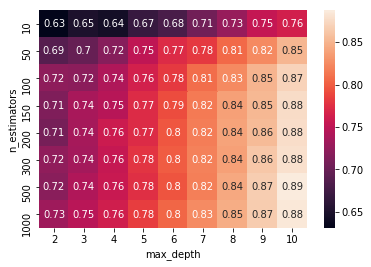

In [725]:
print("Training data AUC heatmap")
print(sns.heatmap(df_trainauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

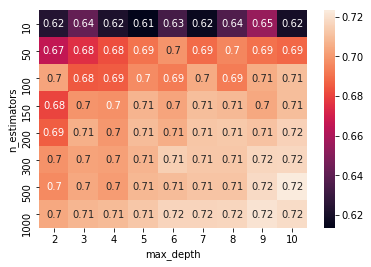

In [726]:
print("Cross validation data AUC heatmap")
print(sns.heatmap(df_cvauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Difference between training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

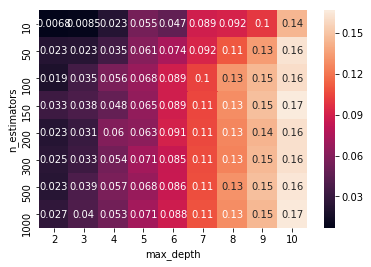

In [727]:
print("Difference between training and cross validation data AUC heatmap")
print(sns.heatmap((df_trainauc-df_cvauc),annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

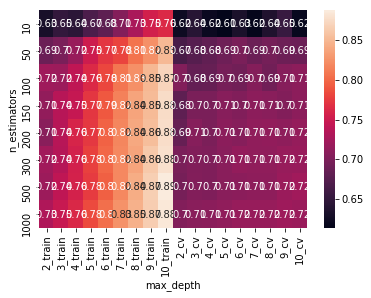

In [728]:
print("Training and cross validation data AUC heatmap")
print(sns.heatmap(df_joined,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

In [739]:
bestne=200
bestmd=3

In [740]:
%%time
clf1=RandomForestClassifier(n_estimators=bestne,max_depth=bestmd,n_jobs=-1,class_weight='balanced')
clf1.fit(X_train_tfidf,y_train1.values.ravel())

Wall time: 4.65 s


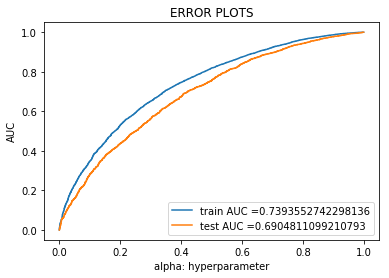

In [741]:
train_fpr1, train_tpr1, thresholds = roc_curve(y_train1,clf1.predict_proba(X_train_tfidf)[:,1])

test_fpr1, test_tpr1, thresholds = roc_curve(y_test1,clf1.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


Train confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

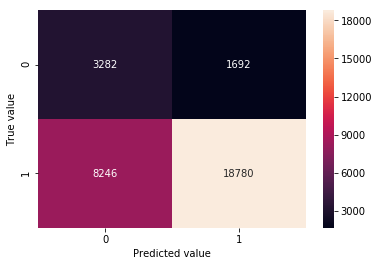

In [742]:
print("Train confusion matrix")
trcm=confusion_matrix(y_train1, clf1.predict(X_train_tfidf))
print(sns.heatmap(trcm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

Test confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

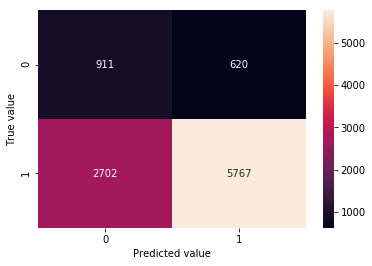

In [743]:
print("Test confusion matrix")
tecm=confusion_matrix(y_test1, clf1.predict(X_test_tfidf))
print(sns.heatmap(tecm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

### 2.4.3 Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [744]:
%%time
for i in range(0,len(md),1):
    for j in range(0,len(ne),1):
        clf1=RandomForestClassifier(n_estimators=ne[j],max_depth=md[i],n_jobs=-1,class_weight='balanced')
        clf1.fit(X_train_avgw2v,y_train2.values.ravel())
        train_fpr1, train_tpr1, thresholds = roc_curve(y_train2,clf1.predict_proba(X_train_avgw2v)[:,1])
        trauc[j][i]=auc(train_fpr1, train_tpr1)
        cv_fpr1, cv_tpr1, thresholds = roc_curve(y_cv2,clf1.predict_proba(X_cv_avgw2v)[:,1])
        cvauc[j][i]=auc(cv_fpr1, cv_tpr1)

Wall time: 31min 1s


In [745]:
trauc=np.array(trauc)
cvauc=np.array(cvauc)
df_trainauc=pd.DataFrame(trauc)
df_trainauc.index=ne
df_trainauc.columns=md
df_cvauc=pd.DataFrame(cvauc)
df_cvauc.index=ne
df_cvauc.columns=md
df_joined=df_trainauc.join(df_cvauc,lsuffix='_train',rsuffix='_cv')

Training data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

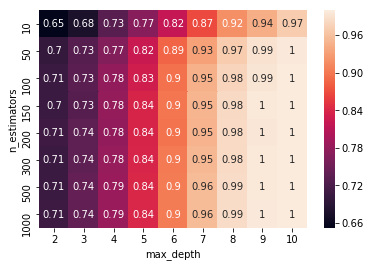

In [746]:
print("Training data AUC heatmap")
print(sns.heatmap(df_trainauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

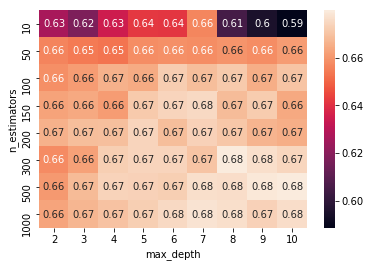

In [747]:
print("Cross validation data AUC heatmap")
print(sns.heatmap(df_cvauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Difference between training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

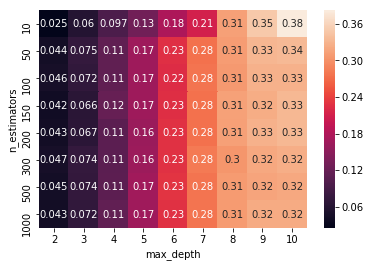

In [748]:
print("Difference between training and cross validation data AUC heatmap")
print(sns.heatmap((df_trainauc-df_cvauc),annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

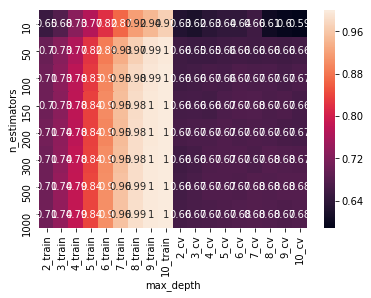

In [749]:
print("Training and cross validation data AUC heatmap")
print(sns.heatmap(df_joined,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

In [750]:
bestne=10
bestmd=2

In [751]:
%%time
clf1=RandomForestClassifier(n_estimators=bestne,max_depth=bestmd,n_jobs=-1,class_weight='balanced')
clf1.fit(X_train_avgw2v,y_train2.values.ravel())

Wall time: 1.35 s


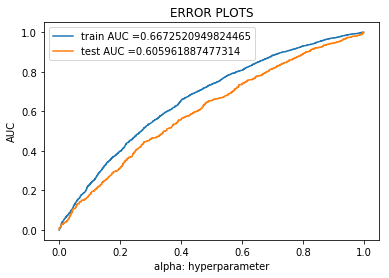

In [752]:
train_fpr1, train_tpr1, thresholds = roc_curve(y_train2,clf1.predict_proba(X_train_avgw2v)[:,1])

test_fpr1, test_tpr1, thresholds = roc_curve(y_test2,clf1.predict_proba(X_test_avgw2v)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


Train confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

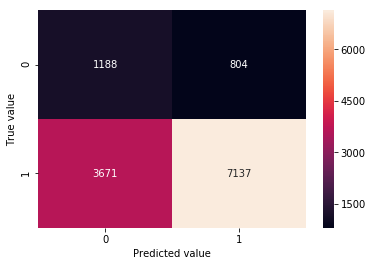

In [753]:
print("Train confusion matrix")
trcm=confusion_matrix(y_train2, clf1.predict(X_train_avgw2v))
print(sns.heatmap(trcm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

Test confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

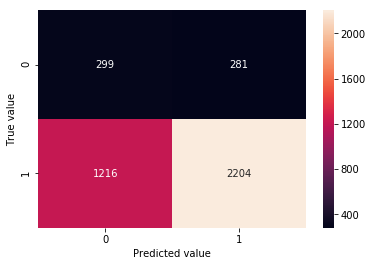

In [754]:
print("Test confusion matrix")
tecm=confusion_matrix(y_test2, clf1.predict(X_test_avgw2v))
print(sns.heatmap(tecm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

### 2.4.4 Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [755]:
for i in range(0,len(md),1):
    for j in range(0,len(ne),1):
        clf1=RandomForestClassifier(n_estimators=ne[j],max_depth=md[i],n_jobs=-1,class_weight='balanced')
        clf1.fit(X_train_tfidfw2v,y_train2.values.ravel())
        train_fpr1, train_tpr1, thresholds = roc_curve(y_train2,clf1.predict_proba(X_train_tfidfw2v)[:,1])
        trauc[j][i]=auc(train_fpr1, train_tpr1)
        cv_fpr1, cv_tpr1, thresholds = roc_curve(y_cv2,clf1.predict_proba(X_cv_tfidfw2v)[:,1])
        cvauc[j][i]=auc(cv_fpr1, cv_tpr1)

In [756]:
trauc=np.array(trauc)
cvauc=np.array(cvauc)
df_trainauc=pd.DataFrame(trauc)
df_trainauc.index=ne
df_trainauc.columns=md
df_cvauc=pd.DataFrame(cvauc)
df_cvauc.index=ne
df_cvauc.columns=md
df_joined=df_trainauc.join(df_cvauc,lsuffix='_train',rsuffix='_cv')

Training data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

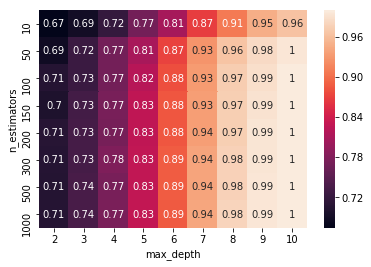

In [757]:
print("Training data AUC heatmap")
print(sns.heatmap(df_trainauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

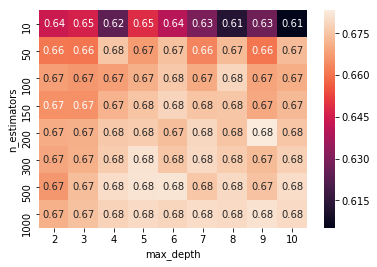

In [758]:
print("Cross validation data AUC heatmap")
print(sns.heatmap(df_cvauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Difference between training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

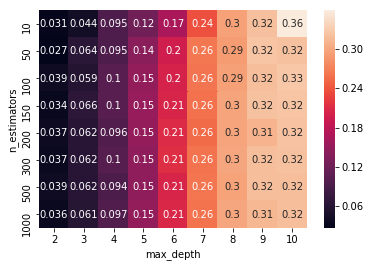

In [759]:
print("Difference between training and cross validation data AUC heatmap")
print(sns.heatmap((df_trainauc-df_cvauc),annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

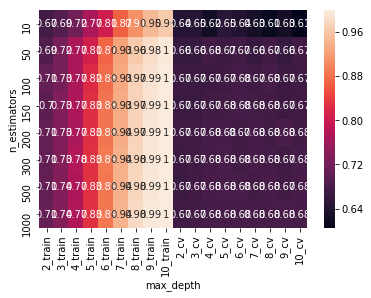

In [760]:
print("Training and cross validation data AUC heatmap")
print(sns.heatmap(df_joined,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

In [761]:
bestne=50
bestmd=2

In [762]:
%%time
clf1=RandomForestClassifier(n_estimators=bestne,max_depth=bestmd,n_jobs=-1,class_weight='balanced')
clf1.fit(X_train_tfidfw2v,y_train2.values.ravel())

Wall time: 3.61 s


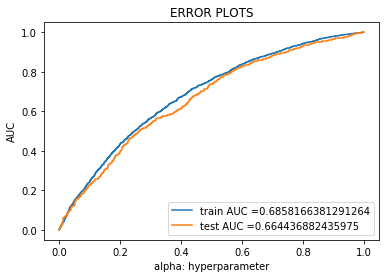

In [763]:
train_fpr1, train_tpr1, thresholds = roc_curve(y_train2,clf1.predict_proba(X_train_tfidfw2v)[:,1])

test_fpr1, test_tpr1, thresholds = roc_curve(y_test2,clf1.predict_proba(X_test_tfidfw2v)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


Train confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

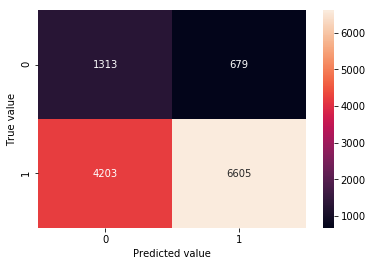

In [764]:
print("Train confusion matrix")
trcm=confusion_matrix(y_train2, clf1.predict(X_train_tfidfw2v))
print(sns.heatmap(trcm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

Test confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

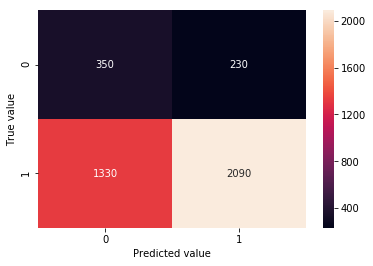

In [765]:
print("Test confusion matrix")
tecm=confusion_matrix(y_test2, clf1.predict(X_test_tfidfw2v))
print(sns.heatmap(tecm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

<h2>2.5 Applying GBDT</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### 2.5.1 Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [766]:
from xgboost import XGBClassifier

In [769]:
%%time
for i in range(0,len(md),1):
    print('\n',md[i])
    for j in range(0,len(ne),1):
        print(ne[j],end=' ')
        clf1=XGBClassifier(n_estimators=ne[j],max_depth=md[i],n_jobs=-1,class_weight='balanced')
        clf1.fit(X_train_bow,y_train1.values.ravel())
        train_fpr1, train_tpr1, thresholds = roc_curve(y_train1,clf1.predict_proba(X_train_bow)[:,1])
        trauc[j][i]=auc(train_fpr1, train_tpr1)
        cv_fpr1, cv_tpr1, thresholds = roc_curve(y_cv1,clf1.predict_proba(X_cv_bow)[:,1])
        cvauc[j][i]=auc(cv_fpr1, cv_tpr1)


 2
10 50 100 150 200 300 500 1000 
 3
10 50 100 150 200 300 500 1000 
 4
10 50 100 150 200 300 500 1000 
 5
10 50 100 150 200 300 500 1000 
 6
10 50 100 150 200 300 500 1000 
 7
10 50 100 150 200 300 500 1000 
 8
10 50 100 150 200 300 500 1000 
 9
10 50 100 150 200 300 500 1000 
 10
10 50 100 150 200 300 500 1000 Wall time: 2h 6min 38s


In [770]:
trauc=np.array(trauc)
cvauc=np.array(cvauc)
df_trainauc=pd.DataFrame(trauc)
df_trainauc.index=ne
df_trainauc.columns=md
df_cvauc=pd.DataFrame(cvauc)
df_cvauc.index=ne
df_cvauc.columns=md
df_joined=df_trainauc.join(df_cvauc,lsuffix='_train',rsuffix='_cv')

Training data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

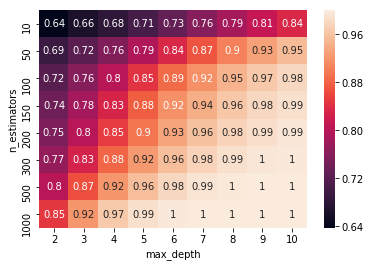

In [771]:
print("Training data AUC heatmap")
print(sns.heatmap(df_trainauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

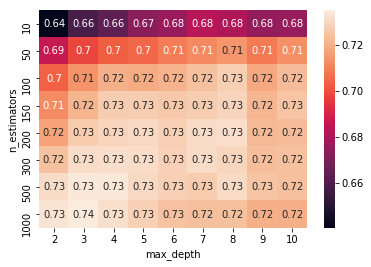

In [772]:
print("Cross validation data AUC heatmap")
print(sns.heatmap(df_cvauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Difference between training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

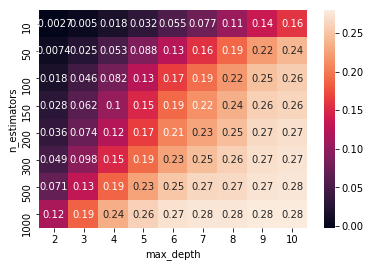

In [773]:
print("Difference between training and cross validation data AUC heatmap")
print(sns.heatmap((df_trainauc-df_cvauc),annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

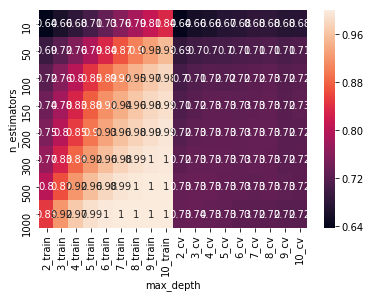

In [774]:
print("Training and cross validation data AUC heatmap")
print(sns.heatmap(df_joined,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

In [792]:
bestne=50
bestmd=2

In [793]:
%%time
clf1=XGBClassifier(n_estimators=bestne,max_depth=bestmd,n_jobs=-1,class_weight='balanced')
clf1.fit(X_train_bow,y_train1.values.ravel())

Wall time: 13 s


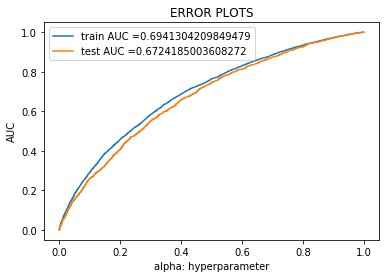

In [794]:
train_fpr1, train_tpr1, thresholds = roc_curve(y_train1,clf1.predict_proba(X_train_bow)[:,1])

test_fpr1, test_tpr1, thresholds = roc_curve(y_test1,clf1.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


Train confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

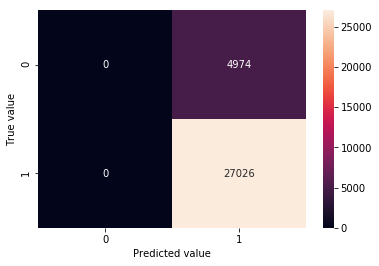

In [795]:
warnings.filterwarnings("ignore")
print("Train confusion matrix")
trcm=confusion_matrix(y_train1, clf1.predict(X_train_bow))
print(sns.heatmap(trcm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

Test confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

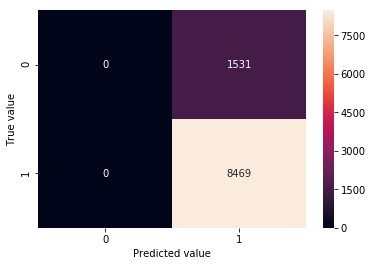

In [796]:
warnings.filterwarnings("ignore")
print("Test confusion matrix")
tecm=confusion_matrix(y_test1, clf1.predict(X_test_bow))
print(sns.heatmap(tecm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

### 2.5.2 Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [797]:
X_train_tfidf=X_train_tfidf.tocsr()
X_cv_tfidf=X_cv_tfidf.tocsr()
X_test_tfidf=X_test_tfidf.tocsr()

In [801]:
%%time
for i in range(0,len(md),1):
    print('\n',md[i])
    for j in range(0,len(ne),1):
        print(ne[j],end=' ')
        clf1=XGBClassifier(n_estimators=ne[j],max_depth=md[i],n_jobs=-1,class_weight='balanced')
        clf1.fit(X_train_tfidf,y_train1.values.ravel())
        train_fpr1, train_tpr1, thresholds = roc_curve(y_train1,clf1.predict_proba(X_train_tfidf)[:,1])
        trauc[j][i]=auc(train_fpr1, train_tpr1)
        cv_fpr1, cv_tpr1, thresholds = roc_curve(y_cv1,clf1.predict_proba(X_cv_tfidf)[:,1])
        cvauc[j][i]=auc(cv_fpr1, cv_tpr1)


 2
10 50 100 150 200 300 500 1000 
 3
10 50 100 150 200 300 500 1000 
 4
10 50 100 150 200 300 500 1000 
 5
10 50 100 150 200 300 500 1000 
 6
10 50 100 150 200 300 500 1000 
 7
10 50 100 150 200 300 500 1000 
 8
10 50 100 150 200 300 500 1000 
 9
10 50 100 150 200 300 500 1000 
 10
10 50 100 150 200 300 500 1000 Wall time: 5h 9min 17s


In [803]:
trauc=np.array(trauc)
cvauc=np.array(cvauc)
df_trainauc=pd.DataFrame(trauc)
df_trainauc.index=ne
df_trainauc.columns=md
df_cvauc=pd.DataFrame(cvauc)
df_cvauc.index=ne
df_cvauc.columns=md
df_joined=df_trainauc.join(df_cvauc,lsuffix='_train',rsuffix='_cv')

Training data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

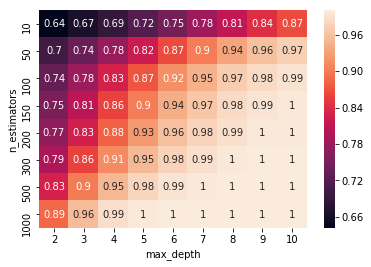

In [804]:
print("Training data AUC heatmap")
print(sns.heatmap(df_trainauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

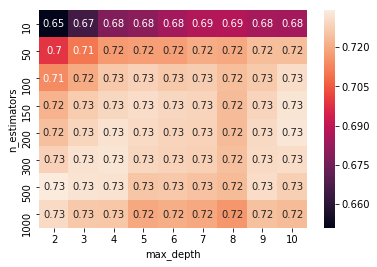

In [805]:
print("Cross validation data AUC heatmap")
print(sns.heatmap(df_cvauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Difference between training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

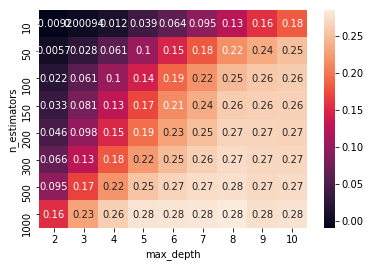

In [806]:
print("Difference between training and cross validation data AUC heatmap")
print(sns.heatmap((df_trainauc-df_cvauc),annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

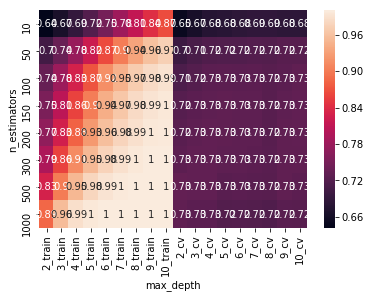

In [807]:
print("Training and cross validation data AUC heatmap")
print(sns.heatmap(df_joined,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

In [808]:
bestne=50
bestmd=2

In [809]:
%%time
clf1=XGBClassifier(n_estimators=bestne,max_depth=bestmd,n_jobs=-1,class_weight='balanced')
clf1.fit(X_train_tfidf,y_train1.values.ravel())

Wall time: 23.6 s


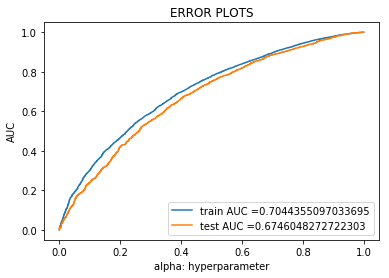

In [810]:
train_fpr1, train_tpr1, thresholds = roc_curve(y_train1,clf1.predict_proba(X_train_tfidf)[:,1])

test_fpr1, test_tpr1, thresholds = roc_curve(y_test1,clf1.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


Train confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

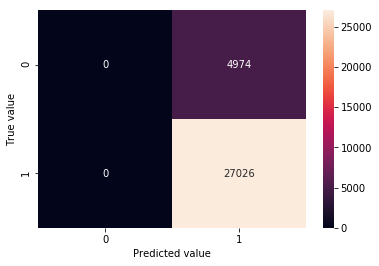

In [811]:
warnings.filterwarnings("ignore")
print("Train confusion matrix")
trcm=confusion_matrix(y_train1, clf1.predict(X_train_tfidf))
print(sns.heatmap(trcm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

Test confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

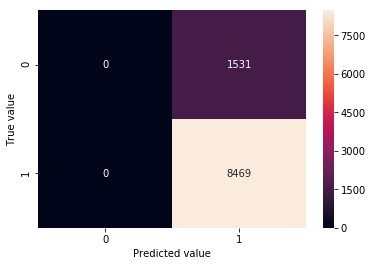

In [812]:
warnings.filterwarnings("ignore")
print("Test confusion matrix")
tecm=confusion_matrix(y_test1, clf1.predict(X_test_tfidf))
print(sns.heatmap(tecm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

### 2.5.3 Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [813]:
%%time
for i in range(0,len(md),1):
    print('\n',md[i])
    for j in range(0,len(ne),1):
        print(ne[j],end=' ')
        clf1=XGBClassifier(n_estimators=ne[j],max_depth=md[i],n_jobs=-1,class_weight='balanced')
        clf1.fit(X_train_avgw2v,y_train2.values.ravel())
        train_fpr1, train_tpr1, thresholds = roc_curve(y_train2,clf1.predict_proba(X_train_avgw2v)[:,1])
        trauc[j][i]=auc(train_fpr1, train_tpr1)
        cv_fpr1, cv_tpr1, thresholds = roc_curve(y_cv2,clf1.predict_proba(X_cv_avgw2v)[:,1])
        cvauc[j][i]=auc(cv_fpr1, cv_tpr1)


 2
10 50 100 150 200 300 500 1000 
 3
10 50 100 150 200 300 500 1000 
 4
10 50 100 150 200 300 500 1000 
 5
10 50 100 150 200 300 500 1000 
 6
10 50 100 150 200 300 500 1000 
 7
10 50 100 150 200 300 500 1000 
 8
10 50 100 150 200 300 500 1000 
 9
10 50 100 150 200 300 500 1000 
 10
10 50 100 150 200 300 500 1000 Wall time: 3h 37min 20s


In [814]:
trauc=np.array(trauc)
cvauc=np.array(cvauc)
df_trainauc=pd.DataFrame(trauc)
df_trainauc.index=ne
df_trainauc.columns=md
df_cvauc=pd.DataFrame(cvauc)
df_cvauc.index=ne
df_cvauc.columns=md
df_joined=df_trainauc.join(df_cvauc,lsuffix='_train',rsuffix='_cv')

Training data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

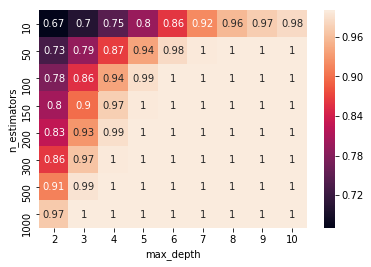

In [815]:
print("Training data AUC heatmap")
print(sns.heatmap(df_trainauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

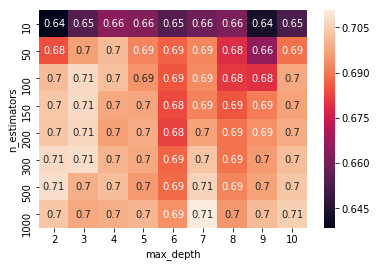

In [816]:
print("Cross validation data AUC heatmap")
print(sns.heatmap(df_cvauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Difference between training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

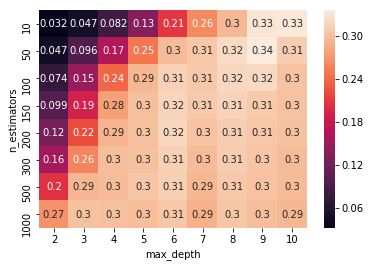

In [817]:
print("Difference between training and cross validation data AUC heatmap")
print(sns.heatmap((df_trainauc-df_cvauc),annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

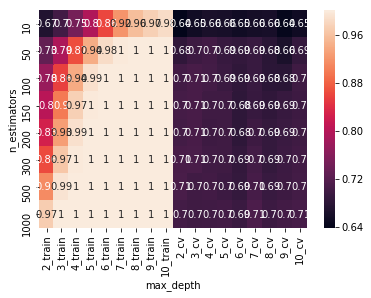

In [818]:
print("Training and cross validation data AUC heatmap")
print(sns.heatmap(df_joined,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

In [819]:
bestne=10
bestmd=2

In [820]:
%%time
clf1=XGBClassifier(n_estimators=bestne,max_depth=bestmd,n_jobs=-1,class_weight='balanced')
clf1.fit(X_train_avgw2v,y_train2.values.ravel())

Wall time: 7.2 s


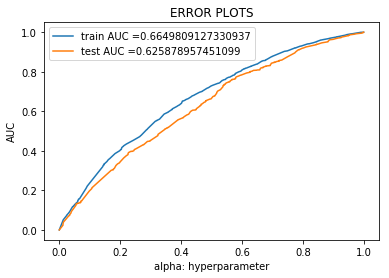

In [822]:
train_fpr1, train_tpr1, thresholds = roc_curve(y_train2,clf1.predict_proba(X_train_avgw2v)[:,1])

test_fpr1, test_tpr1, thresholds = roc_curve(y_test2,clf1.predict_proba(X_test_avgw2v)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


Train confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

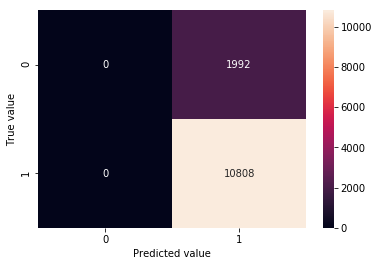

In [823]:
warnings.filterwarnings("ignore")
print("Train confusion matrix")
trcm=confusion_matrix(y_train2, clf1.predict(X_train_avgw2v))
print(sns.heatmap(trcm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

Test confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

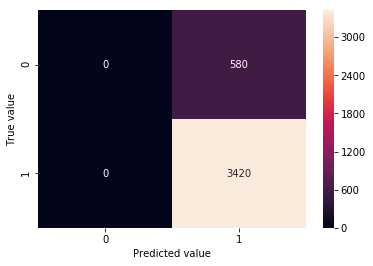

In [824]:
warnings.filterwarnings("ignore")
print("Test confusion matrix")
tecm=confusion_matrix(y_test2, clf1.predict(X_test_avgw2v))
print(sns.heatmap(tecm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

### 2.5.4 Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [825]:
%%time
for i in range(0,len(md),1):
    print('\n',md[i])
    for j in range(0,len(ne),1):
        print(ne[j],end=' ')
        clf1=XGBClassifier(n_estimators=ne[j],max_depth=md[i],n_jobs=-1,class_weight='balanced')
        clf1.fit(X_train_tfidfw2v,y_train2.values.ravel())
        train_fpr1, train_tpr1, thresholds = roc_curve(y_train2,clf1.predict_proba(X_train_tfidfw2v)[:,1])
        trauc[j][i]=auc(train_fpr1, train_tpr1)
        cv_fpr1, cv_tpr1, thresholds = roc_curve(y_cv2,clf1.predict_proba(X_cv_tfidfw2v)[:,1])
        cvauc[j][i]=auc(cv_fpr1, cv_tpr1)


 2
10 50 100 150 200 300 500 1000 
 3
10 50 100 150 200 300 500 1000 
 4
10 50 100 150 200 300 500 1000 
 5
10 50 100 150 200 300 500 1000 
 6
10 50 100 150 200 300 500 1000 
 7
10 50 100 150 200 300 500 1000 
 8
10 50 100 150 200 300 500 1000 
 9
10 50 100 150 200 300 500 1000 
 10
10 50 100 150 200 300 500 1000 Wall time: 5h 2min 29s


In [826]:
trauc=np.array(trauc)
cvauc=np.array(cvauc)
df_trainauc=pd.DataFrame(trauc)
df_trainauc.index=ne
df_trainauc.columns=md
df_cvauc=pd.DataFrame(cvauc)
df_cvauc.index=ne
df_cvauc.columns=md
df_joined=df_trainauc.join(df_cvauc,lsuffix='_train',rsuffix='_cv')

Training data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

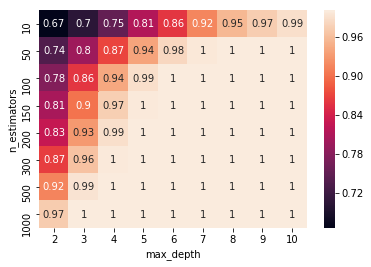

In [827]:
print("Training data AUC heatmap")
print(sns.heatmap(df_trainauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

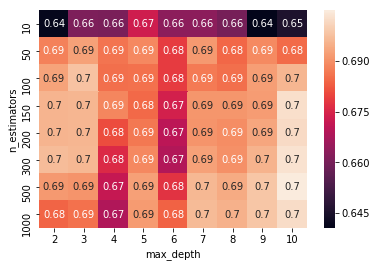

In [828]:
print("Cross validation data AUC heatmap")
print(sns.heatmap(df_cvauc,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Difference between training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

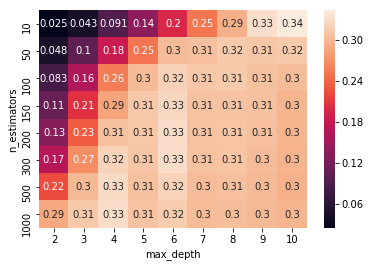

In [829]:
print("Difference between training and cross validation data AUC heatmap")
print(sns.heatmap((df_trainauc-df_cvauc),annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

Training and cross validation data AUC heatmap
AxesSubplot(0.125,0.125;0.62x0.755)


Text(33,0.5,'n_estimators')

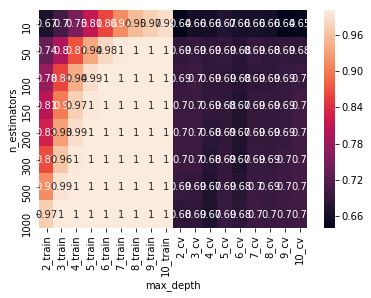

In [830]:
print("Training and cross validation data AUC heatmap")
print(sns.heatmap(df_joined,annot=True))
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

In [831]:
bestne=10
bestmd=2

In [832]:
%%time
clf1=XGBClassifier(n_estimators=bestne,max_depth=bestmd,n_jobs=-1,class_weight='balanced')
clf1.fit(X_train_tfidfw2v,y_train2.values.ravel())

Wall time: 7.32 s


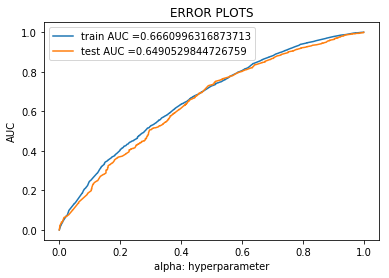

In [833]:
train_fpr1, train_tpr1, thresholds = roc_curve(y_train2,clf1.predict_proba(X_train_tfidfw2v)[:,1])

test_fpr1, test_tpr1, thresholds = roc_curve(y_test2,clf1.predict_proba(X_test_tfidfw2v)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)


Train confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

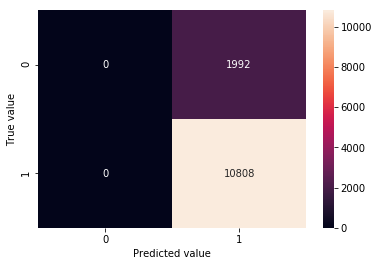

In [834]:
warnings.filterwarnings("ignore")
print("Train confusion matrix")
trcm=confusion_matrix(y_train2, clf1.predict(X_train_tfidfw2v))
print(sns.heatmap(trcm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

Test confusion matrix
AxesSubplot(0.125,0.125;0.62x0.755)


Text(0.5,15,'Predicted value')

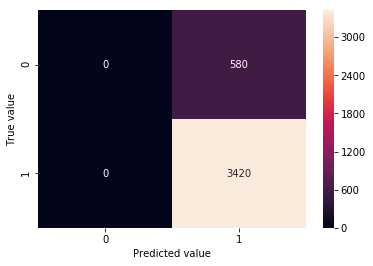

In [835]:
warnings.filterwarnings("ignore")
print("Test confusion matrix")
tecm=confusion_matrix(y_test2, clf1.predict(X_test_tfidfw2v))
print(sns.heatmap(tecm,annot=True, fmt='d'))
plt.ylabel('True value')
plt.xlabel('Predicted value')

<h1>3. Conclusion</h1>

In [836]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
    
xt = PrettyTable()

column_names = ["Vectorizer", "Model", "n_estimators(HP)","max_depth(HP)", "Train AUC", "Test AUC"]

xt.add_column(column_names[0], ["BOW","TFIDF","AVGW2V", "TFIDFW2V","BOW","TFIDF","AVGW2V", "TFIDFW2V"])
xt.add_column(column_names[1], ["Random Forest","Random Forest","Random Forest","Random Forest","XGBoost","XGBoost","XGBoost","XGBoost"])  
xt.add_column(column_names[2], [500,200,10,50,50,50,10,10])
xt.add_column(column_names[3], [2,3,2,2,2,2,2,2])  
xt.add_column(column_names[4], [0.715,0.7393,0.667,0.686,0.694,0.704,0.665,0.666])
xt.add_column(column_names[5], [0.682,0.6905,0.606,0.664,0.672,0.675,0.626,0.65])

print(xt)

+------------+---------------+------------------+---------------+-----------+----------+
| Vectorizer |     Model     | n_estimators(HP) | max_depth(HP) | Train AUC | Test AUC |
+------------+---------------+------------------+---------------+-----------+----------+
|    BOW     | Random Forest |       500        |       2       |   0.715   |  0.682   |
|   TFIDF    | Random Forest |       200        |       3       |   0.7393  |  0.6905  |
|   AVGW2V   | Random Forest |        10        |       2       |   0.667   |  0.606   |
|  TFIDFW2V  | Random Forest |        50        |       2       |   0.686   |  0.664   |
|    BOW     |    XGBoost    |        50        |       2       |   0.694   |  0.672   |
|   TFIDF    |    XGBoost    |        50        |       2       |   0.704   |  0.675   |
|   AVGW2V   |    XGBoost    |        10        |       2       |   0.665   |  0.626   |
|  TFIDFW2V  |    XGBoost    |        10        |       2       |   0.666   |   0.65   |
+------------+-------

__We have found the best hyperparameters for the different vectorizers for both random forest and XGBoost.__

__For Random Forest, TFIDF vectorizer gives us the best Test AUC.__

__For XGBoost, TFIDF vectorizer gives us the best Test AUC__